In [352]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colorbar as colorbar
from matplotlib.colors import TwoSlopeNorm

In [353]:
save_path = '../results'

## Results Testing - Scenario 1: Single supplier smarter

In [354]:
path_df_testing = '../sb3/testing/data/data_testing.csv'
df_testing = pd.read_csv(path_df_testing)

df_testing.drop(['Unnamed: 0'], axis=1, inplace=True)
df_testing['price_setter'] = [x.split('_')[0] for x in df_testing.env_name]
df_testing['patience'] = [x.split('_')[1][1:] for x in df_testing.env_name]
df_testing['ratio'] = [x.split('_')[2][1:] for x in df_testing.env_name]

df_testing.drop_duplicates(subset=['env_name', 'decision_rationale'], keep='last', inplace=True)

env_names = list(set(df_testing.env_name))

In [355]:
df_testing

,env_name,decision_rationale,returns,terminations,returns_sum,returns_avg,returns_std,terminations_pos,terminations_total,terminations_mean,price_setter,patience,ratio
0,decentralized_p1_r0.1,drl,"[1.8074865874, 0, 3.4127062194, 0, 0, 0, 0, 2....","[True, False, True, False, False, False, False...",35527.079935,7.106127e-01,1.471280e+00,12045,49995,0.240924,decentralized,1,0.1
1,decentralized_p1_r0.1,heuristic,"[1.725e-07, 0, -3.65e-08, -9.6e-08, 0, 0, 0, 5...","[True, False, True, True, False, False, False,...",-0.000020,-4.000000e-10,6.680000e-08,22317,49995,0.446385,decentralized,1,0.1
2,decentralized_p1_r0.1,semi-optimal,"[0.531115764, 0, 0.3493110172, 0.4013127917, 0...","[True, False, True, True, False, False, False,...",6095.264898,1.219175e-01,2.012348e-01,20278,49995,0.405601,decentralized,1,0.1
3,decentralized_p10_r0.1,drl,"[0, 0, 0, 0, 0, 0, 5.0281017713, 0, 0, 0, 0, 0...","[False, False, False, False, False, False, Tru...",121448.603149,2.429215e+00,2.614507e+00,35100,49995,0.702070,decentralized,10,0.1
4,decentralized_p10_r0.1,heuristic,"[0, 1.356e-07, 0, 0, 0, -7.3e-08, -3.06e-08, -...","[False, True, False, False, False, True, True,...",-0.000011,-2.000000e-10,1.110000e-07,40018,49995,0.800440,decentralized,10,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,centralized_p10_r10,heuristic,"[0, 0, 0, 0, 0, 0.4099461668414692, 0, 0, 0, 0...","[False, False, False, False, False, True, Fals...",6559.379141,1.312007e-01,5.515098e-01,4191,49995,0.083828,centralized,10,10
77,centralized_p10_r10,optimal,"[0, 1.2132750451564789, 1.5069516003131866, 0,...","[False, True, True, False, False, True, False,...",52863.113576,1.057368e+00,1.651356e+00,21290,49995,0.425843,centralized,10,10
78,centralized_p100_r10,drl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[False, False, False, False, False, False, Fal...",-4769.646554,-9.540247e-02,1.696353e+00,11142,49995,0.222862,centralized,100,10
79,centralized_p100_r10,heuristic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[False, False, False, False, False, False, Fal...",15323.830148,3.065073e-01,8.801616e-01,8353,49995,0.167077,centralized,100,10


-21.28012801280128 54.07340734073407


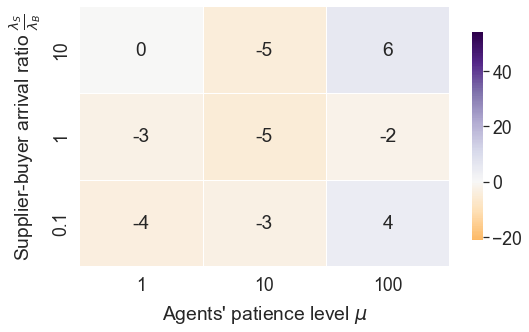

-21.28012801280128 54.07340734073407


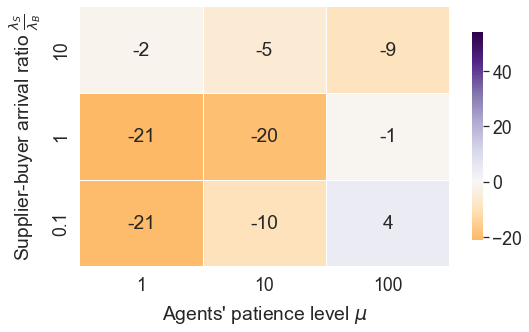

-21.28012801280128 54.07340734073407


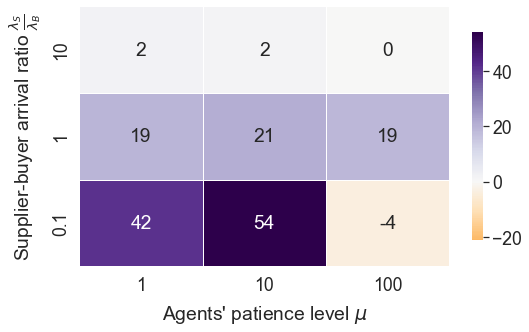

-0.04 0.28300000000000003


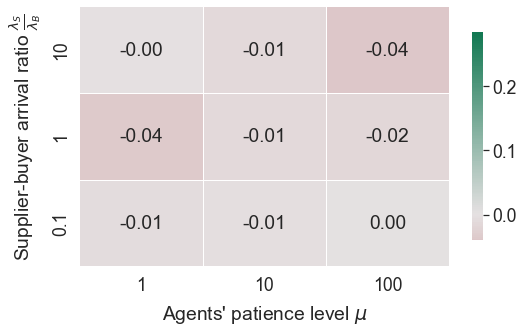

-0.04 0.28300000000000003


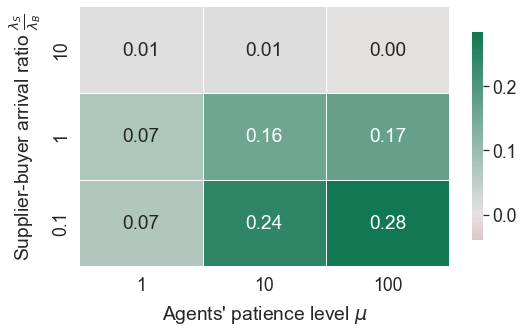

-0.04 0.28300000000000003


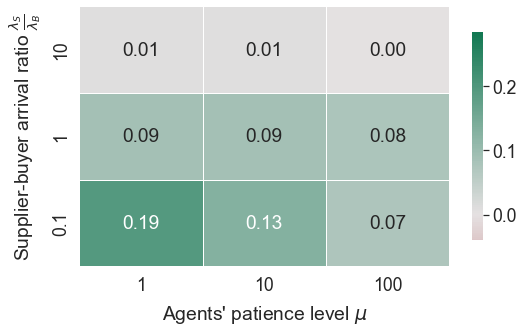

In [356]:
def create_heatmap_testing_diff(price_setter, values):
    
    pivoted = df_testing.pivot_table(index=["price_setter", "patience", "ratio"],
                             columns="decision_rationale",
                             values=values)
    pivoted["drl"] = [round(x,4) for x in pivoted["drl"]]
    pivoted["heuristic"] = [round(x,4) for x in pivoted["heuristic"]]
    pivoted["values_ratio"] = round((pivoted["drl"] - pivoted["heuristic"]),2)
    
    if values == 'terminations_pos':
        pivoted["values_ratio"] = [100*x/49995 for x in pivoted["values_ratio"]]
    elif values == 'returns_avg':
        pivoted["values_ratio"] = [x/10 for x in pivoted["values_ratio"]]
        
    common_vmin = min(pivoted['values_ratio'])
    common_vmax = max(pivoted['values_ratio'])
    print(common_vmin, common_vmax)
    
    # If desired, you can reset the index to return it to a standard DataFrame form
    pivoted = pivoted.reset_index()

    # 1. Filter for one price setter, e.g. "centralized"
    df_filtered = pivoted[pivoted["price_setter"] == price_setter]

    # 2. Pivot so patience is on rows, ratio is on columns, and returns_ratio is the values
    df_heat = df_filtered.pivot(index="ratio", columns="patience", values="values_ratio")
    desired_y_order = ["10", "1", "0.1"]
    desired_x_order = ["1", "10", "100"]
    df_heat = df_heat.reindex(index=desired_y_order, columns=desired_x_order)

    # 3. Create a heatmap with Seaborn
    plt.figure(figsize=(8, 5))
    sns.set_style("whitegrid")
    sns.set(font_scale=1.6)
    color_maps = {
        'returns_avg': mcolors.LinearSegmentedColormap.from_list("MyRedGreyGreen", ["#AE3133", "#E5E1E2", "#127852"], N=256),
        'terminations_pos': 'PuOr'
        }
    fmt = {
        'returns_avg': '.2f',
        'terminations_pos': '.0f'
    }
    sns.heatmap(df_heat, cmap=color_maps[values], annot=True, fmt=fmt[values], center=0, linewidths=0.5, linecolor="white", 
                cbar_kws={"shrink": 0.8}, vmin=common_vmin, vmax=common_vmax)
    #plt.title(f"{price_setter} - {values}")
    plt.xlabel(r"Agents' patience level $\mu$", labelpad=9)
    plt.ylabel(r"Supplier-buyer arrival ratio $\frac{\lambda_S}{\lambda_B}$", labelpad=9) #
    #plt.yticks([])
    plt.tight_layout()
    plt.savefig(save_path+f"/plots/testing/difference/{values}_{price_setter}.png", dpi=300, bbox_inches="tight")
    plt.show()
    

for values in ['terminations_pos', 'returns_avg']:
    for price_setter in ['centralized', 'decentralized', 'hybrid']:
        create_heatmap_testing_diff(price_setter, values)

## avg returns = drl - heuristic return per episode
## terminations_pos = percentage of participating episode in drl vs heuristic

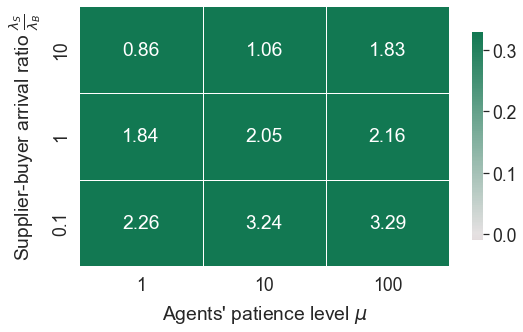

In [365]:
def create_heatmap_single_absolute(price_setter, decision_rationale, values):

    if values == 'terminations_pos':
        common_vmin = min(df_testing[values]/49995*100)
        common_vmax = max(df_testing[values]/49995*100)
    elif values == 'returns_avg':
        common_vmin = min(df_testing[values]/10)
        common_vmax = max(df_testing[values]/10)
    else:
        common_vmin = min(df_testing[values])
        common_vmax = max(df_testing[values])
    
    pivoted = df_testing.pivot_table(index=["price_setter", "patience", "ratio"],
                             columns="decision_rationale",
                             values=values)
    pivoted["drl"] = [round(x,4) for x in pivoted["drl"]]
    pivoted["heuristic"] = [round(x,4) for x in pivoted["heuristic"]]
    pivoted["semi-optimal"] = [round(x,4) for x in pivoted["semi-optimal"]]
    
    if values == 'terminations_pos':
        pivoted["drl"] = [100*x/49995 for x in pivoted["drl"]]
        pivoted["heuristic"] = [100*x/49995 for x in pivoted["heuristic"]]
        pivoted["semi-optimal"] = [100*x/49995 for x in pivoted["semi-optimal"]]
        pivoted["optimal"] = [100*x/49995 for x in pivoted["optimal"]]
    elif values == 'returns_avg':
        pivoted["drl"] = [x/10 for x in pivoted["drl"]]
        pivoted["heuristic"] = [x/10 for x in pivoted["heuristic"]]
        pivoted["semi-optimal"] = [x/10 for x in pivoted["semi-optimal"]]
        pivoted["optimal"] = [x/10 for x in pivoted["optimal"]]
    else:
        pivoted["drl"] = [x for x in pivoted["drl"]]
        pivoted["heuristic"] = [x for x in pivoted["heuristic"]]
        pivoted["semi-optimal"] = [x for x in pivoted["semi-optimal"]]
        pivoted["optimal"] = [x for x in pivoted["optimal"]]

    pivoted = pivoted.reset_index()

    # Filter for one price setter, e.g. "centralized"
    df_filtered = pivoted[pivoted["price_setter"] == price_setter]
    df_heat = df_filtered.pivot(index="ratio", columns="patience", values=decision_rationale)
    desired_y_order = ["10", "1", "0.1"]
    desired_x_order = ["1", "10", "100"]
    df_heat = df_heat.reindex(index=desired_y_order, columns=desired_x_order)

    # Create a heatmap
    plt.figure(figsize=(8, 5))
    sns.set_style("whitegrid")
    sns.set(font_scale=1.6)
    color_maps = {
        'returns_avg': mcolors.LinearSegmentedColormap.from_list("MyRedGreyGreen", ["#AE3133", "#E5E1E2", "#127852"], N=256),
        'terminations_pos': mcolors.LinearSegmentedColormap.from_list("Blue", ["#F5F5F4", "#F5F5F4", "#1740DB"], N=256),
        }
    fmt = {
        'returns_avg': '.2f',
        'terminations_pos': '.0f'
    }
    sns.heatmap(df_heat, cmap=color_maps[values], annot=True, fmt=fmt[values], center=0, linewidths=0.5, linecolor="white", 
                cbar_kws={"shrink": 0.8}, vmin=common_vmin, vmax=common_vmax)
    #plt.title(f"{price_setter} - {decision_rationale} - {values}")
    plt.xlabel(r"Agents' patience level $\mu$", labelpad=9)
    plt.ylabel(r"Supplier-buyer arrival ratio $\frac{\lambda_S}{\lambda_B}$", labelpad=9)
    plt.tight_layout()
    #plt.savefig(save_path+f"/plots/testing/absolute/{values}_{price_setter}_{decision_rationale}.png", dpi=1000, bbox_inches="tight")
    plt.show()

for price_setter in ['centralized']: # , 'centralized', 'hybrid'
    for decision_rationale in ['optimal']: # 'heuristic', 'drl', 'semi-optimal'
        for values in ['returns_avg']: #'terminations_pos', 
            create_heatmap_single_absolute(price_setter, decision_rationale, values)

## avg returns = drl - heuristic return per episode
## terminations_pos = percentage of participating episode in drl vs heuristic

/var/folders/46/wsswctf55vdfp6kz49kfbqtm0000gn/T/ipykernel_51628/744222635.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


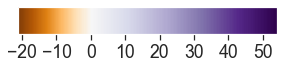

In [151]:
def create_colorbar(color_scheme, vmin, vmax, tick_positions, name):
    cmap = sns.color_palette(color_scheme, as_cmap=True)  # or any other diverging palette

    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    sns.set_style("whitegrid")
    sns.set(font_scale=1.6)

    fig, ax = plt.subplots(figsize=(6, 0.5))
    fig.subplots_adjust(left=0.3)
    plt.tight_layout()

    cb = colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')#, ticks = tick_positions)
    plt.savefig(save_path+f"/plots/testing/absolute/colorbar_{name}.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    
color_scheme = 'PuOr'
vmin, vmax = -21.28012801280128, 54.07340734073407
#tick_positions = np.array([x*0.1 for x in range(1, 10)])
name = 'tbd'

create_colorbar(color_scheme, vmin, vmax, tick_positions, name)

## Results Simulation - Scenario 2: All suppliers smarter

In [380]:
path_df_simulation = '../simulations/data/simulation_data_agg.csv'
df_simulation = pd.read_csv(path_df_simulation)

df_simulation.drop(['Unnamed: 0'], axis=1, inplace=True)
df_simulation['price_setter'] = [x.split('_')[0] for x in df_simulation.env_name]
df_simulation['patience'] = [int(x.split('_')[1][1:]) for x in df_simulation.env_name]
df_simulation['ratio'] = [float(x.split('_')[2][1:]) for x in df_simulation.env_name]
df_simulation['%active_supplier'] = df_simulation['active_suppliers'] / df_simulation['total_suppliers']
df_simulation['%active_supplier_matched'] = df_simulation['matches'] / df_simulation['active_suppliers'] * 100
df_simulation['price'] = df_simulation['revenue'] / df_simulation['matches']
df_simulation['wel_supplier'] = df_simulation['welfare_supplier'] / df_simulation['matches']
df_simulation['wel_customer'] = df_simulation['welfare_customer'] / df_simulation['matches']

df_simulation = df_simulation.loc[(df_simulation['patience'].isin([1,10,100]))&(df_simulation['ratio'].isin([0.1,1,10])),:]

env_names = list(set(df_simulation.env_name))

In [381]:
df_simulation

,env_name,decision_rationale,runs,welfare_total,welfare_supplier,welfare_customer,welfare_platform,costs,valuations,revenue,...,total_suppliers,active_suppliers,price_setter,patience,ratio,%active_supplier,%active_supplier_matched,price,wel_supplier,wel_customer
0,decentralized_p100_r0.1,drl,10,36.601030,26.344943,4.220722,6.035365,27.973346,64.574376,60.353654,...,1978.129,1978.129,decentralized,100,0.1,1.000000,3.530255,0.864257,0.377256,0.060440
1,decentralized_p100_r0.1,heuristic,10,25.665136,0.077056,21.471854,4.116226,36.968981,62.634117,41.162264,...,922.376,922.376,decentralized,100,0.1,1.000000,9.282332,0.480766,0.000900,0.250787
2,hybrid_p10_r10,drl,10,0.762254,0.484490,0.197915,0.079849,0.234149,0.996403,0.798488,...,949.195,539.820,hybrid,10,10.0,0.568713,0.223037,0.663196,0.402401,0.164381
3,hybrid_p10_r10,heuristic,10,3.997625,0.356140,3.496242,0.145242,0.951041,4.948666,1.452424,...,910.347,167.550,hybrid,10,10.0,0.184051,5.335124,0.162482,0.039841,0.391122
4,decentralized_p100_r10,drl,10,1.984456,1.257635,0.452484,0.274337,1.211395,3.195851,2.743366,...,4882.779,4882.779,decentralized,100,10.0,1.000000,0.085955,0.653649,0.299651,0.107811
5,decentralized_p100_r10,heuristic,10,2.646502,0.008480,2.383260,0.254762,2.284377,4.930879,2.547619,...,4595.836,4595.836,decentralized,100,10.0,1.000000,0.205012,0.270390,0.000900,0.252946
6,hybrid_p100_r0.1,drl,10,21.305252,14.400339,3.843095,3.061818,13.156026,34.461278,30.618183,...,3171.169,2283.383,hybrid,100,0.1,0.720045,1.678956,0.798659,0.375625,0.100245
7,hybrid_p100_r0.1,heuristic,10,44.844553,32.577333,4.195156,8.072064,40.071245,84.915798,80.720642,...,630.087,127.374,hybrid,100,0.1,0.202153,70.252956,0.902068,0.364058,0.046882
8,hybrid_p100_r1,drl,10,7.575404,4.576549,2.128155,0.870700,3.259751,10.835155,8.707001,...,4396.780,2225.677,hybrid,100,1.0,0.506206,0.588675,0.664555,0.349302,0.162430
9,hybrid_p100_r1,heuristic,10,22.267430,9.784161,9.648405,2.834864,15.729619,37.997049,28.348644,...,2477.964,613.143,hybrid,100,1.0,0.247438,8.352048,0.553576,0.191060,0.188409


-0.16 0.55


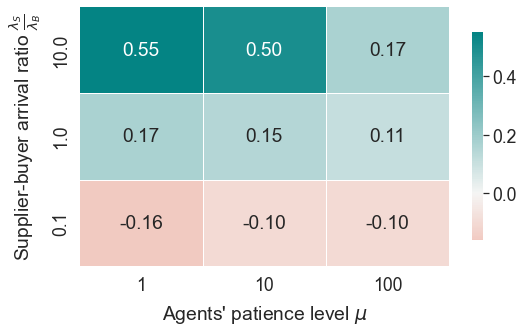

-0.16 0.55


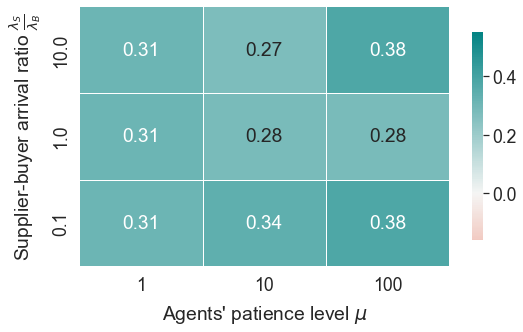

-0.16 0.55


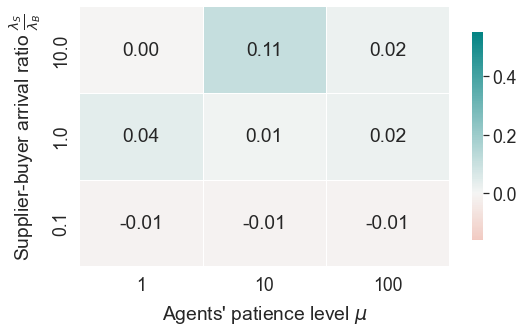

In [387]:
def create_heatmap_testing_diff(price_setter, values):
    
    pivoted = df_simulation.pivot_table(index=["price_setter", "patience", "ratio"],
                             columns="decision_rationale",
                             values=values)

    pivoted["drl"] = [round(x,4) for x in pivoted["drl"]]
    pivoted["heuristic"] = [round(x,4) for x in pivoted["heuristic"]]
    pivoted["values_ratio"] = round((pivoted["drl"] - pivoted["heuristic"]),2)

    common_vmin = min(pivoted['values_ratio'])
    common_vmax = max(pivoted['values_ratio'])
    print(common_vmin, common_vmax)
    
    # If desired, you can reset the index to return it to a standard DataFrame form
    pivoted = pivoted.reset_index()

    # 1. Filter for one price setter, e.g. "centralized"
    df_filtered = pivoted[pivoted["price_setter"] == price_setter]

    # 2. Pivot so patience is on rows, ratio is on columns, and returns_ratio is the values
    df_heat = df_filtered.pivot(index="ratio", columns="patience", values="values_ratio")
    desired_y_order = [10, 1, 0.1]
    desired_x_order = [1, 10, 100]
    df_heat = df_heat.reindex(index=desired_y_order, columns=desired_x_order)

    # 3. Create a heatmap with Seaborn
    plt.figure(figsize=(8, 5))
    sns.set_style("whitegrid")
    sns.set(font_scale=1.6)
    color_maps = {
        '%active_supplier_matched': 'PuOr',
        'price': mcolors.LinearSegmentedColormap.from_list("Cyan", ["#E96348", "#F5F5F4", "#048484"], N=256),
        'wel_supplier': mcolors.LinearSegmentedColormap.from_list("MyRedGreyGreen", ["#AE3133", "#E5E1E2", "#127852"], N=256),
        'wel_customer': mcolors.LinearSegmentedColormap.from_list("MyRedGreyGreen", ["#AE3133", "#E5E1E2", "#127852"], N=256),
        'welfare_platform': mcolors.LinearSegmentedColormap.from_list("MyRedGreyGreen", ["#AE3133", "#E5E1E2", "#127852"], N=256),
        }
    fmt = {
        '%active_supplier_matched': '.0f',
        'price': '.2f',
        'wel_supplier': '.2f',
        'wel_customer': '.2f',
        'welfare_platform': '.2f'
    }
    sns.heatmap(df_heat, cmap=color_maps[values], annot=True, fmt=fmt[values], center=0, linewidths=0.5, linecolor="white", 
                cbar_kws={"shrink": 0.8}, vmin=common_vmin, vmax=common_vmax)
    #plt.title(f"{price_setter} - {values}")
    plt.xlabel(r"Agents' patience level $\mu$", labelpad=9)
    plt.ylabel(r"Supplier-buyer arrival ratio $\frac{\lambda_S}{\lambda_B}$", labelpad=9) #
    #plt.yticks([])
    plt.tight_layout()
    values_nicer = values.replace('%active_supplier_matched', 'conversion')
    plt.savefig(save_path+f"/plots/simulation/difference/{values}_{price_setter}.png", dpi=300, bbox_inches="tight")
    plt.show()
    

values = 'price' # ['%active_supplier_matched', 'price', 'wel_supplier', 'wel_customer', 'welfare_platform']
for price_setter in ['hybrid', 'decentralized', 'centralized']: # 'decentralized', 'hybrid'
    create_heatmap_testing_diff(price_setter, values)


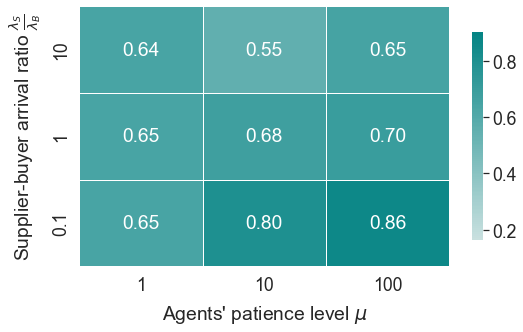

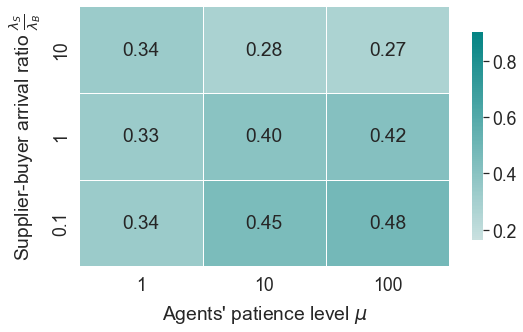

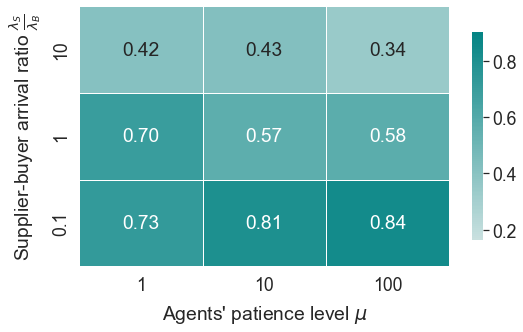

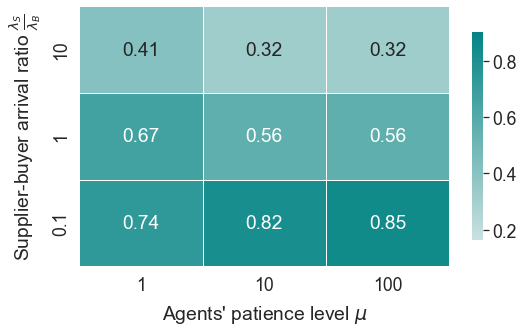

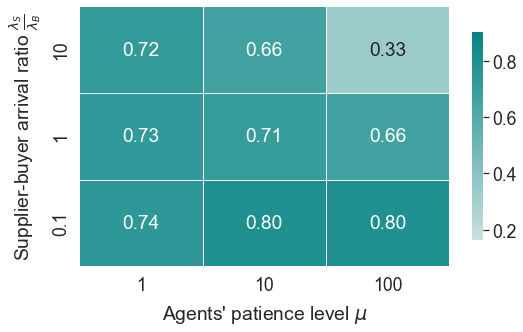

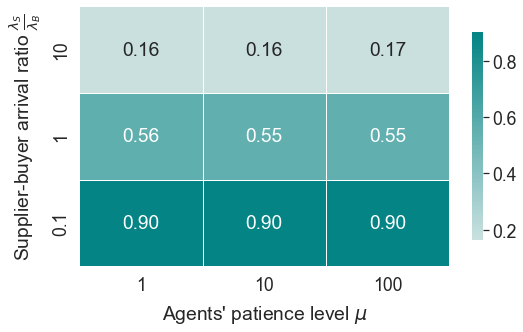

In [394]:
def create_heatmap_all_absolute(price_setter, decision_rationale, values):

    common_vmin = min(df_simulation[values])
    common_vmax = max(df_simulation[values])
    
    pivoted = df_simulation.pivot_table(index=["price_setter", "patience", "ratio"],
                             columns="decision_rationale",
                             values=values)

    pivoted["drl"] = [round(x,4) for x in pivoted["drl"]]
    pivoted["heuristic"] = [round(x,4) for x in pivoted["heuristic"]]
    pivoted = pivoted.reset_index()

    # Filter for one price setter, e.g. "centralized"
    df_filtered = pivoted[pivoted["price_setter"] == price_setter]
    df_heat = df_filtered.pivot(index="ratio", columns="patience", values=decision_rationale)
    
    desired_y_order = [10, 1, 0.1]
    desired_x_order = [1, 10, 100]
    df_heat = df_heat.reindex(index=desired_y_order, columns=desired_x_order)

    # Create a heatmap
    plt.figure(figsize=(8, 5))
    sns.set_style("whitegrid")
    sns.set(font_scale=1.6)
    color_maps = {
        '%active_supplier_matched': mcolors.LinearSegmentedColormap.from_list("Purple", ["#F5F5F4", "#F5F5F4", "#1740DB"], N=256),
        'price': mcolors.LinearSegmentedColormap.from_list("Cyan", ["#F5F5F4", "#F5F5F4", "#048484"], N=256),
        'wel_supplier': mcolors.LinearSegmentedColormap.from_list("MyRedGreyGreen", ["#AE3133", "#E5E1E2", "#127852"], N=256),
        'wel_customer': mcolors.LinearSegmentedColormap.from_list("MyRedGreyGreen", ["#AE3133", "#E5E1E2", "#127852"], N=256),
        'welfare_platform': mcolors.LinearSegmentedColormap.from_list("MyRedGreyGreen", ["#AE3133", "#E5E1E2", "#127852"], N=256),
        }
    fmt = {
        '%active_supplier_matched': '.0f',
        'price': '.2f',
        'wel_supplier': '.2f',
        'wel_customer': '.2f',
        'welfare_platform': '.2f'
    }
    sns.heatmap(df_heat, cmap=color_maps[values], annot=True, fmt=fmt[values], center=0, linewidths=0.5, linecolor="white", 
                cbar_kws={"shrink": 0.8}, vmin=common_vmin, vmax=common_vmax)
    #plt.title(f"{price_setter} - {decision_rationale} - {values}")
    plt.xlabel(r"Agents' patience level $\mu$", labelpad=9)
    plt.ylabel(r"Supplier-buyer arrival ratio $\frac{\lambda_S}{\lambda_B}$", labelpad=9)
    plt.yticks([0.5,1.5,2.5], ["10", "1", "0.1"])
    plt.tight_layout()
    values_nicer = values.replace('%active_supplier_matched', 'conversion')
    plt.savefig(save_path+f"/plots/simulation/absolute/{values}_{price_setter}_{decision_rationale}.png", dpi=1000, bbox_inches="tight")
    plt.show()

for price_setter in ['decentralized', 'centralized', 'hybrid']:
    for decision_rationale in ['drl', 'heuristic']: # 'heuristic', 'drl', 'semi-optimal'
        for values in ['price']: # 'price', 'wel_supplier', 'wel_customer', 'welfare_platform','%active_supplier_matched'
            create_heatmap_all_absolute(price_setter, decision_rationale, values)

## diff conversion rate = %active_supplier_matched
